In [1]:
# load dependencies
import numpy as np
import geopandas as gpd
from osgeo import gdal
import matplotlib.pyplot as plt


(262, 341)


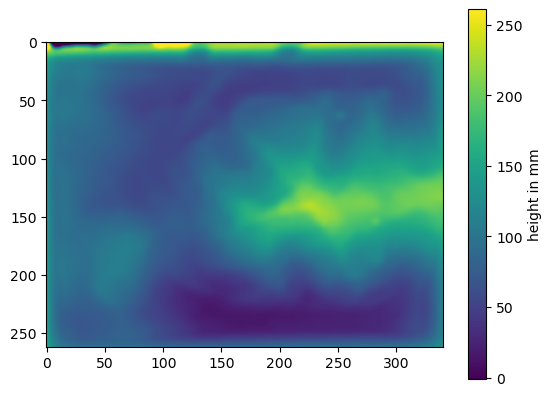

In [2]:
# load sandbox elev from numpy file
data_file = '/Users/tz20896/Documents/PhD/AR_sandbox/laharz_data/sandbox_topo.npy'

sandbox_data = np.load(data_file)

print(np.shape(sandbox_data))

# check results
# !!! map is flipped
fig, ax = plt.subplots(1,1)
box_data = ax.imshow(sandbox_data,)
plt.colorbar(box_data,label='height in mm')

In [3]:
plt.close('all')

In [4]:
# convert data to geotiff
# Sandbox dimensions in mm
SB_LENGTH = 873.0
SB_HEIGHT = 646.0

X_pos = np.linspace(0,SB_LENGTH,np.shape(sandbox_data)[1])
Y_pos = np.linspace(0,SB_HEIGHT,np.shape(sandbox_data)[0])

XX,YY = np.meshgrid(X_pos,Y_pos)

SCALE_factor = 5  # treat mm as m and apply scaling factor
elev_offset = 200 # elevation offset in meters
elev_scale = 3 # scaling factor for height data

BUFFER = 20 
# number of pixels around the edge that get replaced with 0 elevation




In [5]:
# apply buffer

sandbox_zeros = np.zeros_like(sandbox_data)

sandbox_zeros[BUFFER:-BUFFER,BUFFER:-BUFFER] = sandbox_data[BUFFER:-BUFFER,BUFFER:-BUFFER]

sandbox_data = sandbox_zeros

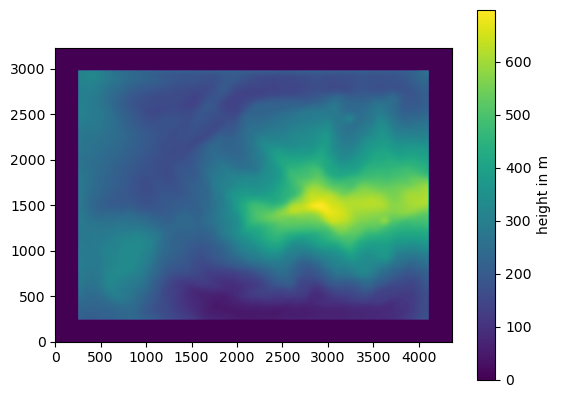

In [6]:
# show results with distance in meters
fig, ax = plt.subplots(1,1)

box_data = ax.imshow(sandbox_data*elev_scale,extent=[0,SB_LENGTH*SCALE_factor,0,SB_HEIGHT*SCALE_factor])
plt.colorbar(box_data,label='height in m')



In [7]:
# prep conversion

# convert meters to degree
m2deg = 111_321

#sample geoextent & resolution - Update it according to your requirement
x1 = 0
y1 = 0
x2 = x1 + SB_LENGTH*SCALE_factor/m2deg
y2 = y1 + SB_HEIGHT*SCALE_factor/m2deg

no_of_bands = 1
width = np.shape(sandbox_data)[1]
height = np.shape(sandbox_data)[0]
x_res = (x1 - x2)/np.shape(sandbox_data)[1]
y_res = (y1 - y2)/np.shape(sandbox_data)[0]
print(no_of_bands, x1, y1, x2, y2, x_res, y_res, width, height)

1 0 0 0.03921093055218692 0.029015190305512886 -0.00011498806613544551 -0.00011074500116607972 341 262


In [8]:
# convert to geotiff
#
# 
# 	
#---------------------------------------------------------------------------------------------------------------------------
# Required modules
from osgeo import gdal, osr, ogr # Python bindings for GDAL
#---------------------------------------------------------------------------------------------------------------------------
 
def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
 
# Define the data extent (min. lon, min. lat, max. lon, max. lat)
extent = [x1, y1, x2, y2] # sandbox exent in deg. 
 
# Export the test array to GeoTIFF ================================================
 
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff')
 
# Get dimensions
nlines = sandbox_data.shape[0]
ncols = sandbox_data.shape[1]
nbands = len(sandbox_data.shape)
data_type = gdal.GDT_Float32 # gdal.GDT_Float32
 
# Create a temp grid
#options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
grid_data = driver.Create('grid_data', ncols, nlines, 1, data_type)#, options)
 
# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(sandbox_data*elev_scale+elev_offset)
 
# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
 
# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nlines, ncols))
 
# Save the file
file_name = '/Users/tz20896/Documents/PhD/AR_SANDBOX/laharz_data/test1/sandbox_elev.tif'
output_file = file_name
print(f'Generated GeoTIFF: {file_name}')
driver.CreateCopy(file_name, grid_data, 0)  
 
# Close the file
driver = None
grid_data = None
 
# Delete the temp grid
import os                
os.remove('grid_data')

Generated GeoTIFF: /Users/tz20896/Documents/PhD/AR_SANDBOX/laharz_data/test1/sandbox_elev.tif


/Applications/anaconda3/envs/laharz-env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [10]:
%matplotlib osx

# read and visualize the saved geotiff
import rasterio
from rasterio.plot import show
src = rasterio.open(output_file)
fig, ax = plt.subplots(1, figsize=(12, 12))
show(src, ax=ax)

<Axes: >